# Task: classification of fire brigade, police car, rescue car

In [14]:
import numpy as np
import tensorflow as tf 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split

# Constants

In [15]:
IMAGE_DIR = './images'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE  = 32
EPOCHS = 10

# Helper functions

In [16]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            print("skip broken image")
            pass
            
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

# Create Generators

In [17]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    IMAGE_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation') # set as validation data

test_generator =  train_datagen.flow_from_directory(
    IMAGE_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True) # set as validation data

Found 473 images belonging to 3 classes.
Found 200 images belonging to 3 classes.
Found 673 images belonging to 3 classes.


# Print some information

In [18]:
print(train_generator.class_indices)

{'fire': 0, 'police': 1, 'rescue': 2}


In [19]:
sample_test_images, labels = next(test_generator)
print(np.argmax(labels, axis=1))

[2 2 0 1 0 0 1 0 1 2 1 1 0 1 1 0 0 1 0 0 1 2 1 0 1 0 1 1 0 0 1 2]


# Display images

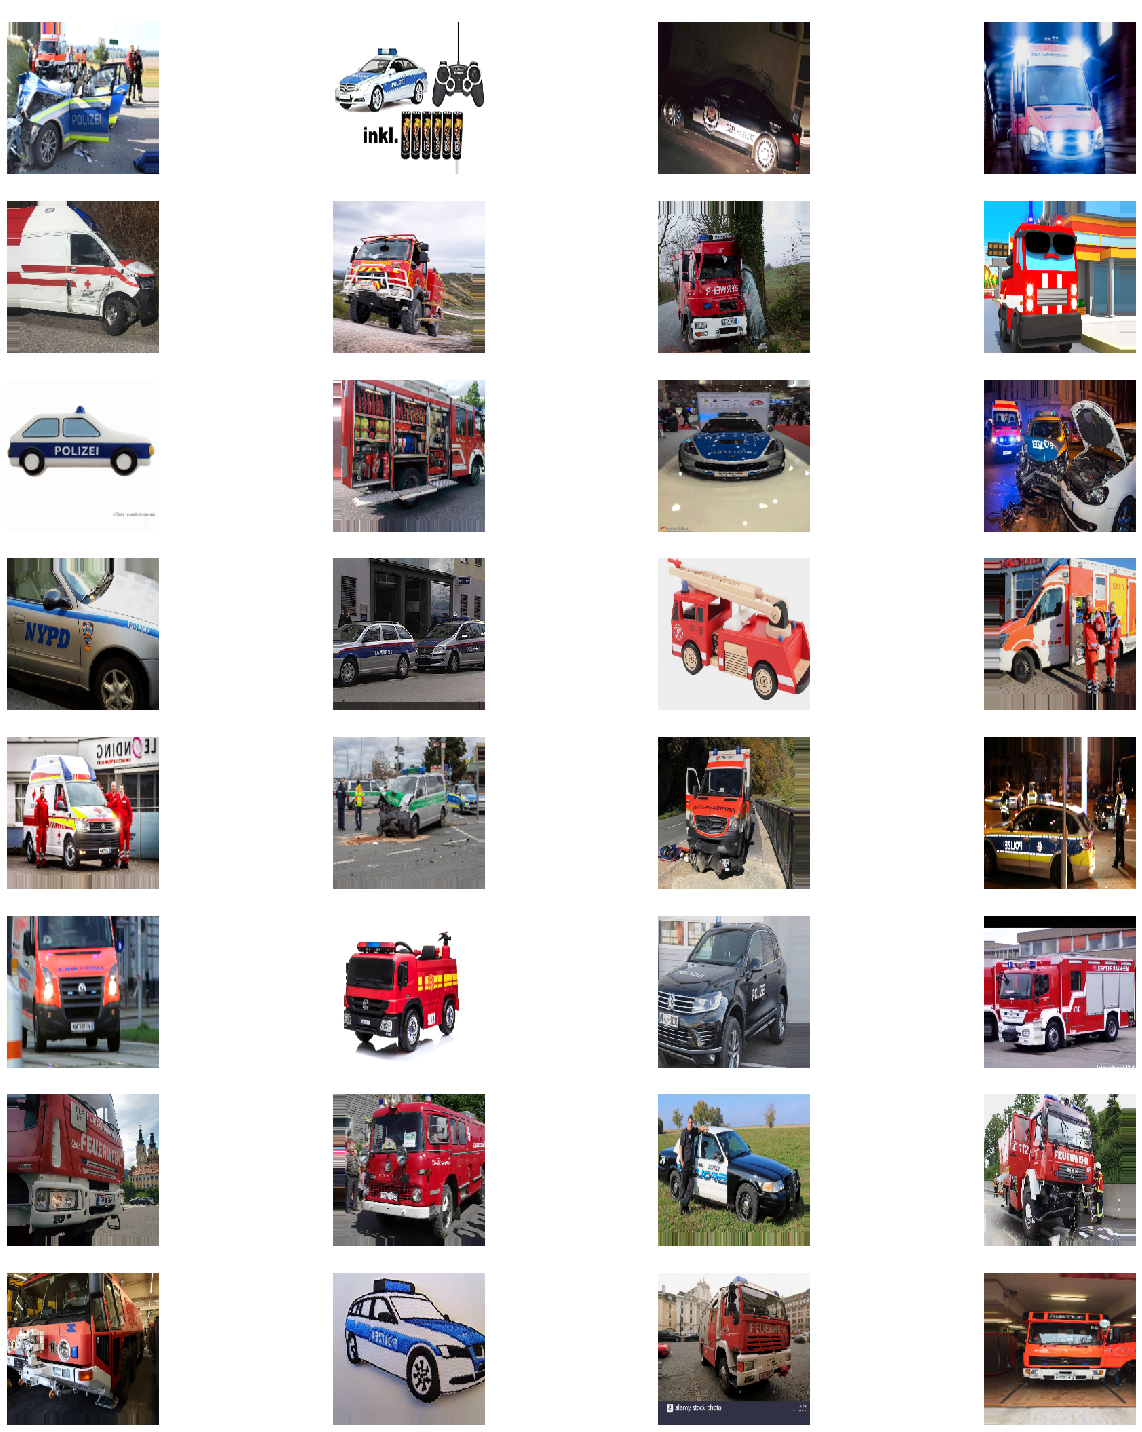

In [20]:
sample_training_images, labels = next(train_generator)
class_label = {v:k for k,v in train_generator.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Create model

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_generator.num_classes, 'softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc")])

In [25]:
history = model.fit_generator(
    skip_broken_images(train_generator),
    steps_per_epoch=train_generator.n / train_generator.batch_size, #use way more steps here: number of samples / batch size
    epochs=EPOCHS, #use way more or use EarlyStopping callback
    validation_data=skip_broken_images(validation_generator),
    validation_steps=5,
    callbacks=[snapshot_callback]
)

Epoch 1/10
14/14 [===========================>..] - ETA: 3s - loss: 1.9004 - categorical_accuracy: 0.3651 - auc: 0.5428
Epoch 00001: saving model to ./snapshots
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./snapshots/assets
15/14 [==============================] - 92s 6s/step - loss: 1.8380 - categorical_accuracy: 0.3975 - auc: 0.5557 - val_loss: 0.9441 - val_categorical_accuracy: 0.6812 - val_auc: 0.8485
Epoch 2/10
14/14 [===========================>..] - ETA: 2s - loss: 0.8617 - categorical_accuracy: 0.6281 - auc: 0.7975
Epoch 00002: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots/assets
15/14 [==============================] - 66s 4s/step - loss: 0.8555 - categorical_accuracy: 0.6321 - auc: 0.8011 - val_loss: 0.6710 - val_categorical_accuracy: 0.7059 - val_auc: 0.8923
Epoch 3/10
14/14 [===========================>..] - ETA: 2s - loss: 0.7314 - categorical_accuracy: 0.6939 - auc: 0.8619

# Plot confusion matrix & ROC

In [35]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc(pred, compare):
    line_width = 2
    number_classes = 3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_num in range(number_classes):
        comp_temp = []
        pred_temp = []
        for idx in range(len(compare)):
            if compare[idx] == class_num:
                comp_temp.append(1)
            else:
                comp_temp.append(0)
            if pred[idx] == class_num:
                pred_temp.append(1)
            else:
                pred_temp.append(0)   
        fpr[class_num], tpr[class_num], _ = roc_curve(comp_temp, pred_temp)
        roc_auc[class_num] = auc(fpr[class_num], tpr[class_num])
    
    colors = cycle(['darkorange', 'cornflowerblue', 'red'])
    for i, color in zip(range(number_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(class_label[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC One vs. all multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Predictions

In [27]:

pred = model.predict(sample_test_images)
pred = np.argmax(pred,axis=1)
compare = np.argmax(labels, axis=1)

In [28]:
print(pred)
print(compare)

[2 2 0 1 0 0 1 0 1 2 1 1 0 1 1 0 0 1 0 2 2 2 1 0 1 0 1 1 0 0 1 0]
[1 1 1 2 2 0 0 0 1 0 1 1 1 1 0 2 2 1 2 1 2 0 1 0 0 0 1 0 0 1 0 0]


# Metric: Accuracy

In [29]:
from sklearn import metrics

score = metrics.accuracy_score(compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.4375


# Metric: Accuracy

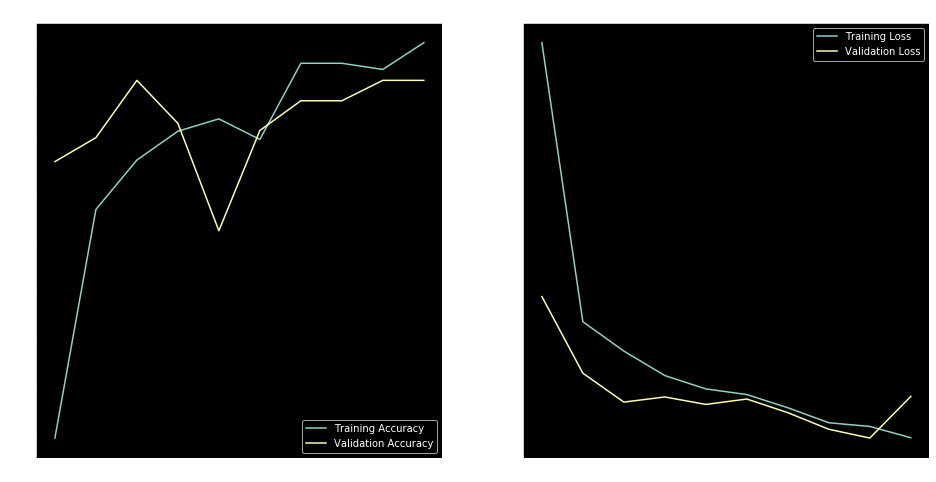

In [30]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Metric: AUC

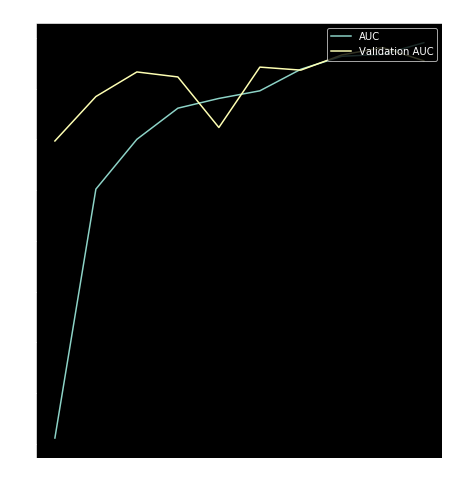

In [31]:
auc = history.history['auc']
val_auc = history.history['val_auc']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC')
plt.show()

# Metric: Confusion Matrix 

Confusion matrix, without normalization
[[6 5 2]
 [3 7 3]
 [4 1 1]]
Normalized confusion matrix
[[0.46 0.38 0.15]
 [0.23 0.54 0.23]
 [0.67 0.17 0.17]]


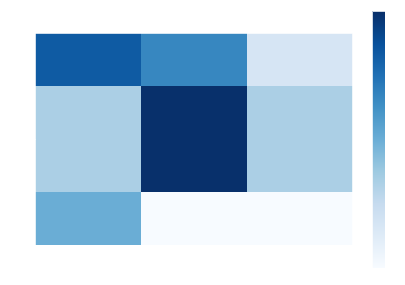

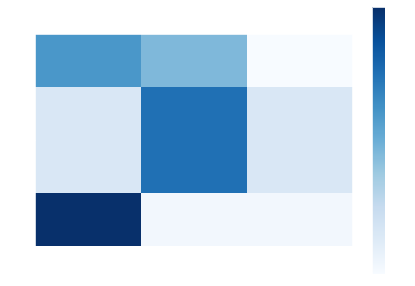

In [32]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
class_labels = {v:k for k,v in test_generator.class_indices.items()}
cm = confusion_matrix(compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, class_label)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_labels, title='Normalized confusion matrix')

plt.show()

# Metric: ROC

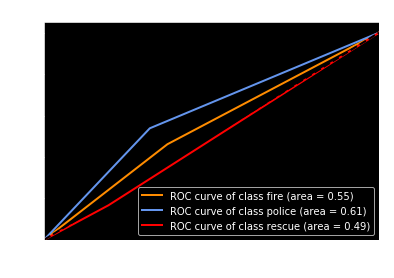

In [36]:
plot_roc(pred,compare)

# Save model

In [ ]:
model.save('cars.h5')